##### Import Library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.stats import truncnorm
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
from scipy.stats import norm
from ROOT import TFile, TTree

# Add the parent directory of simpleparameterisation to the sys.path list
sys.path.append('../')

# Now you can import simpleparameterisation from the new location
import TPCevt as TPC


##### Helper Function and Constant

In [4]:
def driftsigma_trans(z, det):
    return np.sqrt(2*z*det.D_xy/det.vdrift)

def driftsigma_long(z, det):
    return np.sqrt(2*z*det.D_z/det.vdrift)

nsigma_extend=3
thresh=1e1

##### Main Function

In [5]:
def getData(f, saveevt):
    # Get Center Coordinate
    z0_values = np.asarray([evt.z0 for evt in f.data])
    max_z = np.max(z0_values)
    min_z = np.min(z0_values)  
    center_z = (max_z - min_z)/2

    for i, evt in enumerate(f.data):
        if i == saveevt:
            x = np.asarray(evt.x) / 10 + center_z / 10
            y = np.asarray(evt.y) / 10 + center_z / 10
            z = np.asarray(evt.z) / 10 + center_z / 10
            Edep = np.asarray(evt.edep) * 1000
            PrimaryEvt = np.stack((x, y, z, Edep))
            break
    return PrimaryEvt

# def getData2(f, saveevt):
    # Get Center Coordinate
    z0_values = np.asarray([evt.z0 for evt in f.data])
    max_z = np.max(z0_values)
    min_z = np.min(z0_values)  
    center_z = (max_z - min_z)/2
    
    
    # Shift Coordinate
    for i, evt in enumerate(f.data):
        x = np.asarray(evt.x) / 10 + center_z / 10
        y = np.asarray(evt.y) / 10 + center_z / 10
        z = np.asarray(evt.z) / 10 + center_z / 10
        Edep = np.asarray(evt.edep) * 1000
        PrimaryEvt = np.stack((x, y, z, Edep))
        if i == saveevt:
            break
    return PrimaryEvt

def generateCarriers(PrimaryEvt, det):
    nip_list = np.random.poisson(PrimaryEvt[3]/det.wval)
    return np.append(PrimaryEvt, [nip_list], axis=0)


def driftCarriers(PrimaryEvtNIP, det):
    NIP = PrimaryEvtNIP[4].astype(int)
    z_list = PrimaryEvtNIP[2].repeat(NIP)
    DriftedEvt = np.array([
        np.arange(len(NIP)).repeat(NIP),
        PrimaryEvtNIP[0].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det )),
        PrimaryEvtNIP[1].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det )),
        (PrimaryEvtNIP[2].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det )))/det.vdrift,
    ])
    return DriftedEvt


def gainAndReadout(DriftedEvt, det, nsigma_extend=3, thresh=1e1):
    minvals = np.array([DriftedEvt[1].min(),DriftedEvt[2].min(), DriftedEvt[3].min() ])
    maxvals = np.array([DriftedEvt[1].max(),DriftedEvt[2].max(), DriftedEvt[3].max() ])
    nsigma_extend = 3
    PSFmean_extend = nsigma_extend * det.PSFstd + det.PSFmean
    x_range = (minvals[0] - PSFmean_extend, maxvals[0] + PSFmean_extend)
    y_range = (minvals[1] - PSFmean_extend, maxvals[1] + PSFmean_extend)
    dt_range = (minvals[2] - nsigma_extend * det.gain_sigma_t, maxvals[2] + nsigma_extend * det.gain_sigma_t)
    # Calculate ReadoutGrid
    ReadoutGrid = np.mgrid[
                np.floor(x_range[0] / det.pitch_x) * det.pitch_x:
                np.ceil(x_range[1] / det.pitch_x) * det.pitch_x:
                det.pitch_x,
                np.floor(y_range[0] / det.pitch_y) * det.pitch_y:
                np.ceil(y_range[1] / det.pitch_y) * det.pitch_y:
                det.pitch_y,
                np.floor(dt_range[0] / det.samplerate) * det.samplerate:
                np.ceil(dt_range[1] / det.samplerate) * det.samplerate:
                det.samplerate
                ]

    pos = np.stack(ReadoutGrid, axis=3)
    ReadoutEvt = None
    for i in range(len(DriftedEvt[1])):
        thisGain = np.random.exponential(scale=det.gain_mean)
        rv = multivariate_normal([DriftedEvt[1][i], DriftedEvt[2][i], DriftedEvt[3][i]], np.diag([det.PSFstd, det.PSFstd, det.gain_sigma_t]))
        if ReadoutEvt is None:
            #The factor pitch_x*pitch_y*sample_rate converts from probability density 
            #to 'normalised' probability
            ReadoutEvt = rv.pdf(pos)*det.pitch_x*det.pitch_y*det.samplerate*thisGain
        else:
            ReadoutEvt += rv.pdf(pos)*det.pitch_x*det.pitch_y*det.samplerate*thisGain
    themask = ReadoutEvt >= thresh
    if np.sum(themask) == 0:
        print('No channels above threshold!')
        return pd.DataFrame(columns=['x', 'y', 'dt', 'Nel'])
    try:
        return pd.DataFrame({'x': ReadoutGrid[0][themask].flatten(), 'y': ReadoutGrid[1][themask].flatten(), 
            'dt': ReadoutGrid[2][themask].flatten(), 'Nel': ReadoutEvt[themask]})
    except:
        print(f'DriftedEvt: {DriftedEvt}')
        print(f'themask: {themask}\nReadoutGrid[0]: {ReadoutGrid[0]}\nReadoutEvt: {ReadoutEvt}\nReadoutGrid: {ReadoutGrid}')
        print(f'ReadoutGrid.shape: {ReadoutGrid.shape}, ReadoutEvt.shape: {ReadoutEvt.shape}, themask.shape = {themask.shape}')
        raise

def printPrimary(PrimaryEvt):
    print(' x        y        z       Edep   ')
    for i in range(len(PrimaryEvt[0])):
        x = PrimaryEvt[0][i]
        y = PrimaryEvt[1][i]
        dt = PrimaryEvt[2][i]
        Edep = PrimaryEvt[3][i]
        print(f' {x:.4f}  {y:.4f}  {dt:.4f}  {Edep:.4f}')

def printPrimaryNIP(PrimaryEvtNIP):
    print(' x       y        z        Edep    NIP')
    for i in range(len(PrimaryEvtNIP[0])):
        x = PrimaryEvtNIP[0][i]
        y = PrimaryEvtNIP[1][i]
        dt = PrimaryEvtNIP[2][i]
        Edep = PrimaryEvtNIP[3][i]
        NIP = PrimaryEvtNIP[4][i]
        print(f' {x:.4f}  {y:.4f}  {dt:.4f}  {Edep:.4f}  {NIP:.0f} ')

def printDrifted(DriftedEvt):
    print('pidx   x        y        dt')
    for i in range(len(DriftedEvt[0])):
        pidx = DriftedEvt[0][i]
        x = DriftedEvt[1][i]
        y = DriftedEvt[2][i]
        dt = DriftedEvt[3][i]
        print(f'{pidx:.0f}      {x:.4f}  {y:.4f}  {dt:.4f} ')


def plotReadout(ReadoutEvt):
    plt.figure(1)
    projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
    plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, s=((projectxy.Nel/np.max(projectxy.Nel))**0.5)*1000)
    plt.colorbar()
    plt.title(" X-Y Chart ")
    # plt.savefig('export/chart_X-Y.png')

    plt.figure(2)
    projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectxdt.x,projectxdt.dt, c=projectxdt.Nel, s=((projectxdt.Nel/np.max(projectxdt.Nel))**0.5)*1000)
    plt.colorbar()
    plt.title(" X-dT Chart ")
    # plt.savefig('export/chart_X-dT.png')

    plt.figure(3)
    projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectydt.y,projectydt.dt, c=projectydt.Nel, s=((projectydt.Nel/np.max(projectydt.Nel))**0.5)*1000)
    plt.colorbar()
    plt.title(" Y-dT Chart ")
    # plt.savefig('export/chart_Y-dT.png')

    plt.show()

##### Main Program

In [8]:
# Define the Detector
det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")

# Open ROOT FIle
f = TFile.Open("../../data/simOut_28796KShell.root")

##### Primary Event

In [127]:
%%timeit
saveevt = 1
PrimaryEvt = getData(f, saveevt)

4.81 s ± 258 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
saveevt = 1
PrimaryEvt = getData(f, saveevt)
printPrimary(PrimaryEvt)

 x        y        z       Edep   
 23.9622  26.8518  26.8149  0.0437
 23.9624  26.8520  26.8149  0.0838
 23.9623  26.8521  26.8149  0.1366
 23.9621  26.8518  26.8149  0.0494
 23.9614  26.8500  26.8151  0.0220
 23.9576  26.8481  26.8163  0.6658
 23.9568  26.8459  26.8145  0.3760
 23.9573  26.8446  26.8128  0.4339
 23.9571  26.8461  26.8127  0.0160
 23.9577  26.8449  26.8134  1.0524


##### Carrier Event

In [129]:
%%timeit
PrimaryEvtNIP = generateCarriers(PrimaryEvt, det)

17.2 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [10]:
PrimaryEvtNIP = generateCarriers(PrimaryEvt, det)
printPrimaryNIP(PrimaryEvtNIP)

 x       y        z        Edep    NIP
 23.9622  26.8518  26.8149  0.0437  5 
 23.9624  26.8520  26.8149  0.0838  2 
 23.9623  26.8521  26.8149  0.1366  3 
 23.9621  26.8518  26.8149  0.0494  2 
 23.9614  26.8500  26.8151  0.0220  2 
 23.9576  26.8481  26.8163  0.6658  32 
 23.9568  26.8459  26.8145  0.3760  8 
 23.9573  26.8446  26.8128  0.4339  16 
 23.9571  26.8461  26.8127  0.0160  1 
 23.9577  26.8449  26.8134  1.0524  48 


##### Drifted Event

In [134]:
%%timeit
DriftedEvt = driftCarriers(PrimaryEvtNIP, det)

61.1 µs ± 1.91 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
DriftedEvt = driftCarriers(PrimaryEvtNIP, det)
printDrifted(DriftedEvt)

pidx   x        y        dt
0      23.9720  26.7828  0.1583 
0      24.0334  26.6942  0.1567 
0      23.9080  26.9106  0.1572 
0      23.7935  26.6288  0.1571 
0      23.9585  26.7168  0.1569 
1      23.9237  26.8548  0.1588 
1      23.9790  27.0097  0.1564 
2      23.8616  26.9532  0.1584 
2      23.9964  27.0371  0.1582 
2      23.8418  26.6603  0.1591 
3      24.0602  27.0178  0.1583 
3      23.8884  26.7122  0.1571 
4      23.9068  26.8039  0.1570 
4      24.0464  26.7837  0.1586 
5      23.8261  26.8598  0.1571 
5      23.9895  26.9957  0.1573 
5      24.0428  26.9723  0.1571 
5      24.0137  26.8854  0.1584 
5      23.7156  26.7315  0.1579 
5      23.9704  26.9152  0.1574 
5      23.9344  26.7421  0.1580 
5      23.9610  26.8948  0.1587 
5      23.9531  26.9093  0.1585 
5      23.7974  27.0186  0.1572 
5      23.9416  27.0691  0.1581 
5      24.1680  27.1016  0.1568 
5      24.1043  26.7514  0.1583 
5      23.9752  26.9148  0.1585 
5      24.0871  26.7655  0.1566 
5      23.9208 

##### Readout Event

In [135]:
%%timeit
ReadoutEvt = gainAndReadout(DriftedEvt, det, nsigma_extend=3)

21 ms ± 830 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
ReadoutEvt = gainAndReadout(DriftedEvt, det, nsigma_extend=3)
ReadoutEvt

,x,y,dt,Nel
0,23.6,26.4,0.157,49.220555
1,23.6,26.4,0.158,122.791934
2,23.6,26.4,0.159,88.500550
3,23.6,26.5,0.157,339.999062
4,23.6,26.5,0.158,1536.452415
...,...,...,...,...
204,24.2,27.1,0.158,3898.168953
205,24.2,27.1,0.159,9324.903872
206,24.2,27.2,0.157,2410.487069
207,24.2,27.2,0.158,636.816336


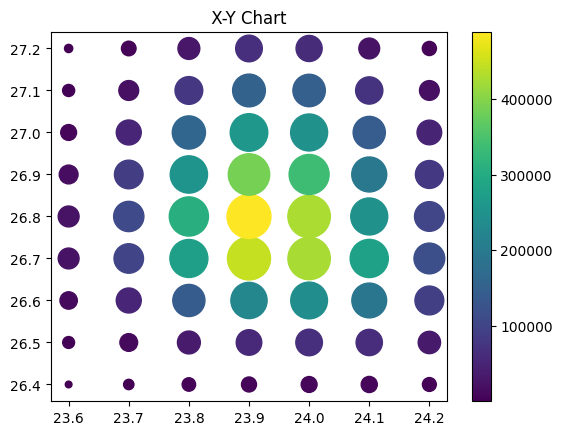

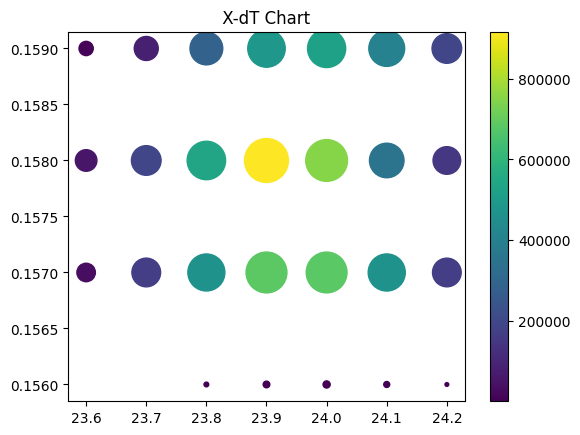

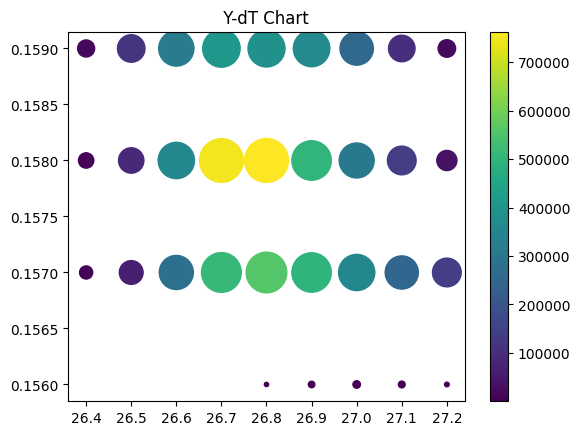

In [13]:
plotReadout(ReadoutEvt)

In [12]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('ReadoutEvt', 7780),
 ('DriftedEvt', 3136),
 ('LogNorm', 1688),
 ('TFile', 1688),
 ('TTree', 1688),
 ('PrimaryEvtNIP', 528),
 ('PrimaryEvt', 448),
 ('driftCarriers', 152),
 ('driftsigma_long', 152),
 ('driftsigma_trans', 152),
 ('gainAndReadout', 152),
 ('generateCarriers', 152),
 ('getData', 152),
 ('open', 152),
 ('plotReadout', 152),
 ('printDrifted', 152),
 ('printPrimary', 152),
 ('printPrimaryNIP', 152),
 ('TPC', 72),
 ('f', 72),
 ('np', 72),
 ('pd', 72),
 ('plt', 72),
 ('det', 56),
 ('multivariate_normal', 56),
 ('norm', 56),
 ('truncnorm', 56),
 ('nsigma_extend', 28),
 ('saveevt', 28),
 ('thresh', 24)]

7421681.336569891


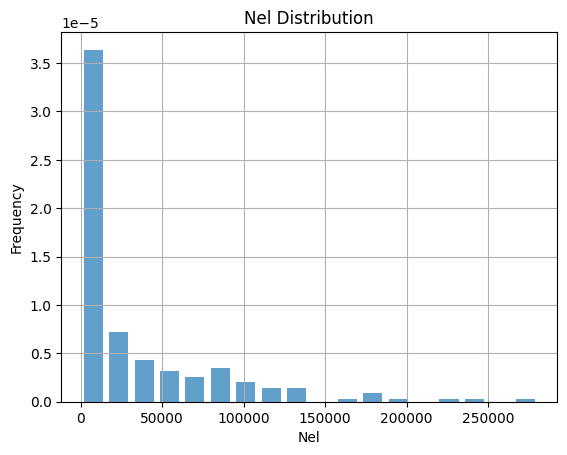

In [14]:
from scipy.stats import norm
ReadoutEvt = gainAndReadout(DriftedEvt, det, nsigma_extend=3)
print(ReadoutEvt['Nel'].sum())
plt.hist(ReadoutEvt['Nel'], bins='auto', alpha=0.7, rwidth=0.75, density=True)

plt.xlabel('Nel')
plt.ylabel('Frequency')
plt.title('Nel Distribution')
plt.grid(True)
plt.show()